# Train Full Net

Workflow loop for this NB:
- Run data pipeline cell
    - it retrieves the model as trained so far. 
- train with fit method
- record new acc and val_acc the results in a list
- inspect: plot
- save the model
- repeat as desired. 

# 0) Retrieve previous iteration of model

In [ ]:
## retrieve model
from tensorflow import keras
model = keras.models.load_model('../saved_models/train_full_net/')

## 1) Data pipeline

In [1]:
import numpy as np
from glob import glob
import os
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt


## even a pre-trained model needs data:

# 1. Sort paths to files

IMAGE_SIZE = 224
path = '../beachlitter/'
images = sorted(glob(os.path.join(path, "images/*.jpg"))) # list of strings
masks = sorted(glob(os.path.join(path, "maskpngs/*.png"))) 

from sklearn.model_selection import train_test_split

def sort_paths(path, split=0.1):
    # PATH = "gs://dmcherney/beachlitter/"
    # glob(file_pattern) gives a list of strings satisfying the pattern
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "maskpngs/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)
    
    #shuffle with the same random seed to make sure masks stay with images.
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = sort_paths(path)

#2 functions to read images: path -> PIL -> array

def read_image(path): #takes in a path, gives out a np array
    path = path.decode() # neede because this function is in a tf pipe
    # open image
    im = PIL.Image.open(path).resize((IMAGE_SIZE,IMAGE_SIZE))
    # image to tensor
    im = tf.keras.utils.img_to_array(im, data_format=None, dtype='float32')
    # normalize image
    im = im/255.
    return im

def read_mask(path):
    path = path.decode() # neede because this function is in a tf pipe
    # open mask
    ma = PIL.Image.open(path).resize((IMAGE_SIZE,IMAGE_SIZE))
    # mask to tensor
    ma = tf.keras.utils.img_to_array(ma, data_format=None, dtype='float32')
    # change catagory numbers from 1 to 8 into 0 to 7
    ma[:,:,0] -= 1
    # one hot encode
    ma = to_categorical(ma[:,:,0],num_classes=8, dtype='float32')
    return ma

# arrays to tensorflow tensors:
def tf_parse(x, y): # takes in 2 paths, not lists
    def _parse(x, y): # takes in 2 paths
        x = read_image(x) 
        y = read_mask(y)
        return x, y # gives out 2 np.arrays

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32]) #takes in 2 paths, gives out 2 tf.tesors
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3]) # seems redundant, but for now it is bouble check
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 8])
    return x, y # tf.tesors 

# 3 organize data into tf dataset of tf tensors
def tf_dataset(x, y, batch=8): #takes in x : list of paths, y : list of paths
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

train_dataset = tf_dataset(train_x, train_y) # input: lists of filenames . Output: to batched tf datasets of parsed images
valid_dataset = tf_dataset(valid_x, valid_y)


2022-04-18 01:11:34.011989: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
# network architecture and fitting tools
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.callbacks import TensorBoard 
# from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import datetime


## 2) Train with the fit method

In [3]:
# options first:
LR = 1e-4 #learning rate
opt = tf.keras.optimizers.Nadam(LR)
BATCH = 8 
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH
log_dir = "../saved_models/train_full_net/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # for tensorboard logs
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    # EarlyStopping(monitor='val_loss', 
    #               patience=5, 
    #               restore_best_weights=True # lets me save the model.
    #                      ),
    TensorBoard(log_dir=log_dir, histogram_freq=1, #for histogram computation each epoc 
                              )
]

#call fit
res = model.fit(
    train_dataset, # this actas as both X and y
    validation_data=valid_dataset,
    epochs=10,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/10
350/350 [==============================] - 715s 2s/step - loss: 0.2106 - accuracy: 0.9275 - val_loss: 0.3655 - val_accuracy: 0.8840 - lr: 1.0000e-05
Epoch 2/10
350/350 [==============================] - 652s 2s/step - loss: 0.2098 - accuracy: 0.9277 - val_loss: 0.3662 - val_accuracy: 0.8839 - lr: 1.0000e-05
Epoch 3/10
350/350 [==============================] - 650s 2s/step - loss: 0.2091 - accuracy: 0.9280 - val_loss: 0.3668 - val_accuracy: 0.8838 - lr: 1.0000e-05
Epoch 4/10
350/350 [==============================] - 703s 2s/step - loss: 0.2084 - accuracy: 0.9282 - val_loss: 0.3673 - val_accuracy: 0.8838 - lr: 1.0000e-05
Epoch 5/10
350/350 [==============================] - 672s 2s/step - loss: 0.2078 - accuracy: 0.9284 - val_loss: 0.3678 - val_accuracy: 0.8837 - lr: 1.0000e-05
Epoch 6/10
350/350 [==============================] - 656s 2s/step - loss: 0.2070 - accuracy: 0.9286 - val_loss: 0.3664 - val_accuracy: 0.8847 - lr: 1.0000e-06


# 2.1) Save model

In [6]:
model.save('saved_models/train_full_net/')

### 2.1.1) pickle the model

In [45]:
import pickle
pickle.dump(model, open('../saved_models/train_full_net/model.p', 'wb'))

INFO:tensorflow:Assets written to: ram://29fe7693-d3ad-4259-a09a-4c3e309c91de/assets


## 2.2) Save training data

In [4]:
res.history['accuracy'] #plz append  list below

[0.9274779558181763,
 0.9277387857437134,
 0.9279875755310059,
 0.9282177090644836,
 0.9284343719482422,
 0.9286169409751892]

In [9]:
res.history['val_accuracy']# plz append list below

[0.8839845657348633,
 0.8838964700698853,
 0.8838297128677368,
 0.8837904930114746,
 0.8837418556213379,
 0.884652853012085]

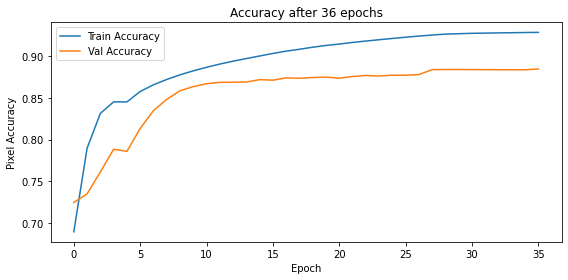

In [12]:
#these are the lists to append to.... and ya, there is a better way. You live and you learn.
accuracy = [0.6894,
 0.7896,
 0.8314,
 0.8453,
 0.8452,  
 0.8576928973197937,
 0.865735650062561,
 0.8721243143081665,
 0.8776670694351196,
 0.882483720779419,
 0.8867453336715698,
 0.8906000256538391,
 0.8940563797950745,
 0.897223711013794,
 0.9002857208251953,
 0.9033260941505432,
 0.9061297178268433,
           0.9083449840545654, 0.9108049869537354, 0.9129146337509155,
           0.9146112203598022,
 0.9165432453155518,
 0.9182037115097046,
 0.9198031425476074,
 0.9213364124298096,
 0.922804057598114,
 0.9242048859596252,
 0.9254130125045776,
 0.9265604615211487,
 0.9270027875900269,
0.9274779558181763,
 0.9277387857437134,
 0.9279875755310059,
 0.9282177090644836,
 0.9284343719482422,
 0.9286169409751892]



val_accuracy = [0.7246,
0.7349,
0.7612,
0.7884,
0.7859, 
0.813338041305542,
 0.8347760438919067,
 0.8482456207275391,
 0.8586015105247498,
 0.8635578751564026,
 0.8670501112937927,
 0.8686763048171997,
 0.8688589930534363,
 0.8690656423568726,
 0.8719239234924316,
 0.87130206823349,
 0.8740574717521667,
               0.8735323548316956, 0.8744650483131409, 0.8749801516532898,
               0.8736944794654846,
 0.8756821155548096,
 0.8769240975379944,
 0.8762944340705872,
 0.8772681355476379,
 0.8771633505821228,
 0.8779798150062561,
 0.8839176893234253,
 0.884066104888916,
 0.8840916156768799,
               0.8839845657348633,
 0.8838964700698853,
 0.8838297128677368,
 0.8837904930114746,
 0.8837418556213379,
 0.884652853012085]

plt.figure(figsize=(8,4))
plt.plot(accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.title(f'Accuracy after {len(accuracy)} epochs')
plt.tight_layout()
plt.savefig('images/train_full_net_accuracy.png', transparent = True);

# 3) Tensorboard

In [4]:
%load_ext tensorboard
%tensorboard --logdir ../saved_models/train_full_net/logs/fit/
# this is empty becauyse of later file re-organization

# 4) visualizing results

In [5]:
# need these two functions, but without the decoding, which was for tf pipelining
# so I will rename them with _p for post, predict, whatever
def read_image_p(path): #takes in a path, gives out a np array
    # path = path.decode() # neede because this function is in a tf pipe
    # open image
    im = PIL.Image.open(path).resize((IMAGE_SIZE,IMAGE_SIZE))
    # image to tensor
    im = tf.keras.utils.img_to_array(im, data_format=None, dtype='float32')
    # normalize image
    im = im/255.
    return im

def read_mask_p(path):
    # path = path.decode() # neede because this function is in a tf pipe
    # open mask
    ma = PIL.Image.open(path).resize((IMAGE_SIZE,IMAGE_SIZE))
    # mask to tensor
    ma = tf.keras.utils.img_to_array(ma, data_format=None, dtype='float32')
    # change catagory numbers from 1 to 8 into 0 to 7
    ma[:,:,0] -= 1
    # one hot encode
    ma = to_categorical(ma[:,:,0],num_classes=8, dtype='float32')
    return ma

**Overlay mask**

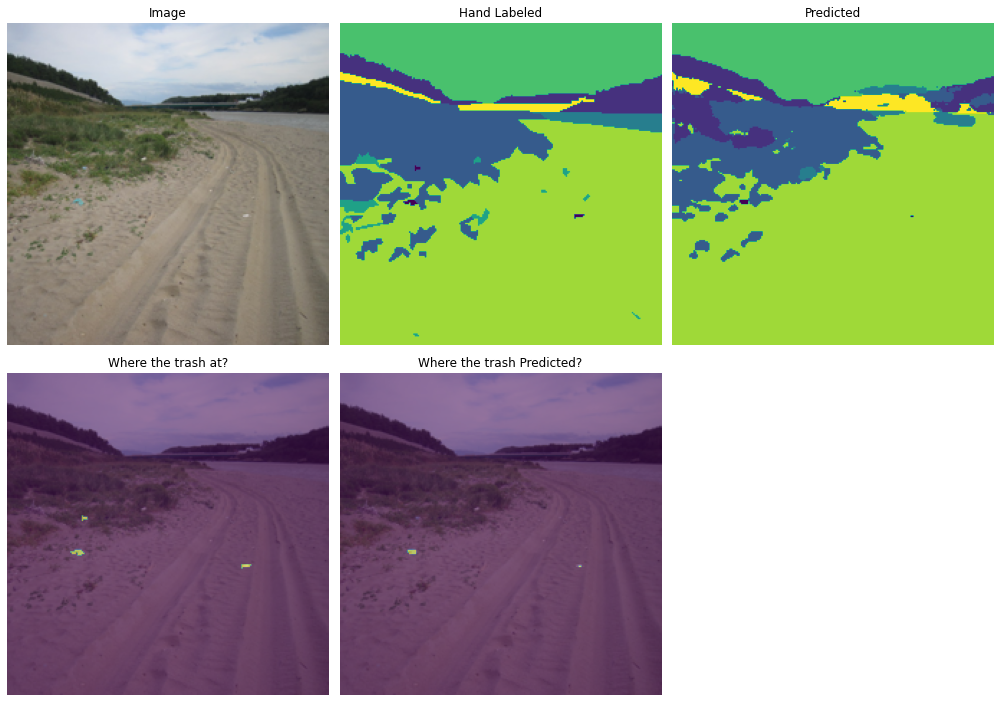

In [7]:
index = 10

fig = plt.figure(figsize=(14, 10))
fig.add_subplot(2, 3, 1 )
plt.axis('off')
plt.title('Image');
plt.imshow(read_image_p(test_x[index]))
fig.add_subplot(2, 3, 2) 
plt.axis('off')
plt.imshow(np.reshape(K.argmax( read_mask_p(test_y[index]),axis=-1) +1, (224,224,1) ) )
plt.title('Hand Labeled');
fig.add_subplot(2, 3,3)
plt.axis('off')
pred = model.predict(np.expand_dims(read_image_p(test_x[index]), axis=0))
plt.imshow(np.reshape( K.argmax(pred[0,:,:,:],            axis=-1)+1   ,(224,224,1) )); # will be 1 to 8
plt.title('Predicted');

# overlays
# on hand labeled
fig.add_subplot(2, 3, 4 )
plt.axis('off')
plt.imshow(read_image_p(test_x[index]), alpha=1)
plt.imshow(np.reshape(K.argmax( read_mask_p(test_y[index]),axis=-1) +1 ==1, (224,224,1) ) , alpha=.5)
plt.title('Where the trash at?');
#on predicted
fig.add_subplot(2, 3, 5 )
plt.axis('off')
plt.imshow(read_image_p(test_x[index]), alpha=1)
plt.imshow(np.reshape( K.argmax(pred[0,:,:,:],            axis=-1)+1   ==1,(224,224,1) ) , alpha =.5); # will be 1 to 8
plt.title('Where the trash Predicted?')
plt.tight_layout()
plt.savefig("../images/train_full_net.png" );
